# Probability Estimation and Ensembles

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, brier_score_loss, mean_squared_error, r2_score, roc_auc_score, log_loss, accuracy_score, confusion_matrix, classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor

In [59]:
import warnings
warnings.filterwarnings("ignore")

<div align="justify">

Another import class of methods is *ensemble learning*, such as bagging or boosting, which are especially popular in machine learning due to their ability to improve accuracy of (point) predictions. 
Since such methods produce a (large) set of predictors $h_1, \ldots, h_M$ instead of a single hypothesis, it is tempting to produce probability estimates following basic frequentist principles. In the simplest case (of classification), each prediction $h_i(\vec{x})$ can be interpreted as a "vote" in favor of a class $y \in \mathcal{Y}$, and probabilities can be estimated by relative frequencies\,---\,needless to say, probabilities constructed in this way tend to be biased and are not necessarily well calibrated. Especially important in this field are tree-based methods such as random forests ({cite:t}`brei_rf01,krup_pe14`).  
<!-- \citep{brei_rf01,krup_pe14} -->

</div>

<div align="justify">

Obviously, while standard probability estimation is a viable approach to representing uncertainty in a prediction, 
there is no explicit distinction between different types of uncertainty. 
Methods falling into this category are mostly concerned with the aleatoric part of the overall uncertainty[^footNoteIdentifier].

</div>

[^footNoteIdentifier]: Yet, as will be seen later on, one way to go beyond mere aleatoric uncertainty is to combine the above methods, for example learning ensembles of probabilistic predictors. 
 <!-- (cf.\ Section \ref{sec:m1}) -->

## Classification Uncertainty

<div align="justify">

Let us first take a look at classifiers for ensemble learning and uncertainty quantification. 
Below we first generate a synthetic dataset, 
then we apply bagging, boosting, and random forest classifiers to calculate the performance in terms of the accuracy and classification report. 

</div>

In [61]:
X, y = make_classification(n_samples=1000, n_classes=2, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging.fit(X_train, y_train)
y_bagging_pred = bagging.predict(X_test)

boosting = AdaBoostClassifier(estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
boosting.fit(X_train, y_train)
y_boosting_pred = boosting.predict(X_test)

random_forest = RandomForestClassifier(n_estimators=50, random_state=42)
random_forest.fit(X_train, y_train)
y_rf_pred = random_forest.predict(X_test)

def calculate_classification_scores(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, output_dict=True)
    return accuracy, cm, cr

bagging_accuracy, bagging_cm, bagging_report = calculate_classification_scores(y_test, y_bagging_pred)
boosting_accuracy, boosting_cm, boosting_report = calculate_classification_scores(y_test, y_boosting_pred)
rf_accuracy, rf_cm, rf_report = calculate_classification_scores(y_test, y_rf_pred)

print(f"Bagging - Accuracy: {bagging_accuracy:.4f}")
print(f"Boosting - Accuracy: {boosting_accuracy:.4f}")
print(f"Random Forest - Accuracy: {rf_accuracy:.4f}")

Bagging - Accuracy: 0.8700
Boosting - Accuracy: 0.8500
Random Forest - Accuracy: 0.8500


In [62]:
df_bagging = pd.DataFrame(bagging_report).transpose()
df_bagging

,precision,recall,f1-score,support
0,0.853333,0.882759,0.867797,145.00
1,0.886667,0.858065,0.872131,155.00
accuracy,0.870000,0.870000,0.870000,0.87
macro avg,0.870000,0.870412,0.869964,300.00
weighted avg,0.870556,0.870000,0.870036,300.00


In [63]:
df_boosting = pd.DataFrame(boosting_report).transpose()
df_boosting

,precision,recall,f1-score,support
0,0.833333,0.862069,0.847458,145.00
1,0.866667,0.838710,0.852459,155.00
accuracy,0.850000,0.850000,0.850000,0.85
macro avg,0.850000,0.850389,0.849958,300.00
weighted avg,0.850556,0.850000,0.850042,300.00


In [64]:
df_rf = pd.DataFrame(rf_report).transpose()
df_rf

,precision,recall,f1-score,support
0,0.816456,0.889655,0.851485,145.00
1,0.887324,0.812903,0.848485,155.00
accuracy,0.850000,0.850000,0.850000,0.85
macro avg,0.851890,0.851279,0.849985,300.00
weighted avg,0.853071,0.850000,0.849935,300.00


<div align="justify">

We observe that the bagging approach achieves the highest accuracy, 
suggesting that bagging might be more robust in terms of handling variance in the data due to its ensemble nature. 
Boosting improves model performance iteratively by focusing on misclassified instances, 
which might have caused it to overfit slightly, given that its accuracy is a bit lower. 
Random forest can effectively handle class imbalance by averaging multiple decision trees, which reduces variance and helps in capturing the diversity of the data by showing a higher precision for Class 1 and a higher recall for Class 0. 

Now let us have a look at the predicted probabilities and the variability in predictions from different methods with ensemble to gauge the aleatoric uncertainty. 
- *Bagging*: We can see the variation in predicted probabilities from different trees in the ensemble.
- *Boosting*: We can infer the uncertainty from the changes in predictions across the boosting rounds. 
- *Random forests*: We can analyze the variability in predicted probabilities from different trees in the forest like bagging method. 

</div>

In [ ]:
y_bagging_prob = np.array([tree.predict_proba(X_test) for tree in bagging.estimators_])
bagging_uncertainty = np.std(y_bagging_prob, axis=0).mean(axis=1)

y_boosting_prob = np.array([estimator.predict_proba(X_test) for estimator in boosting.estimators_])
boosting_uncertainty = np.std(y_boosting_prob, axis=0).mean(axis=1)

y_rf_prob = np.array([tree.predict_proba(X_test) for tree in random_forest.estimators_])
rf_uncertainty = np.std(y_rf_prob, axis=0).mean(axis=1)

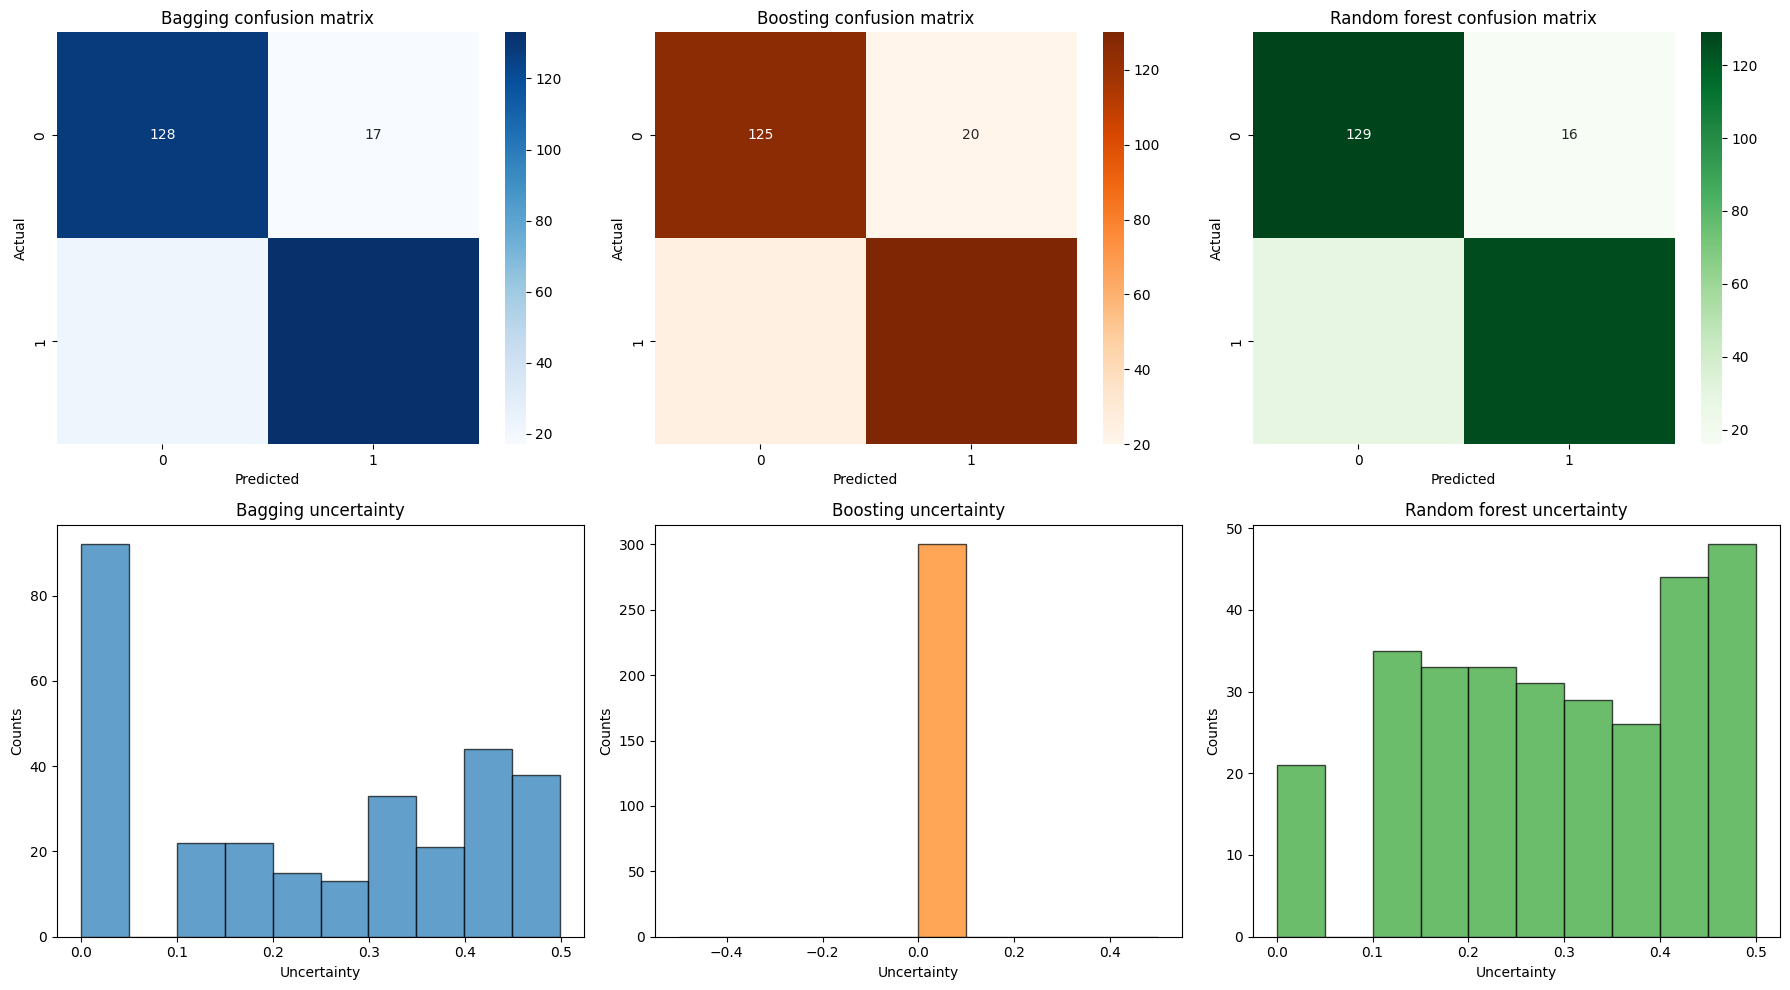

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

sns.heatmap(bagging_cm, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title('Bagging confusion matrix')
axs[0, 0].set_xlabel('Predicted')
axs[0, 0].set_ylabel('Actual')

sns.heatmap(boosting_cm, annot=True, fmt='d', cmap='Oranges', ax=axs[0, 1])
axs[0, 1].set_title('Boosting confusion matrix')
axs[0, 1].set_xlabel('Predicted')
axs[0, 1].set_ylabel('Actual')

sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axs[0, 2])
axs[0, 2].set_title('Random forest confusion matrix')
axs[0, 2].set_xlabel('Predicted')
axs[0, 2].set_ylabel('Actual')

axs[1, 0].hist(bagging_uncertainty, bins=10, edgecolor='k', color='tab:blue', alpha=0.7)
axs[1, 0].set_title('Bagging uncertainty')
axs[1, 0].set_xlabel('Uncertainty')
axs[1, 0].set_ylabel('Counts')

axs[1, 1].hist(boosting_uncertainty, bins=10, edgecolor='k', color='tab:orange', alpha=0.7)
axs[1, 1].set_title('Boosting uncertainty')
axs[1, 1].set_xlabel('Uncertainty')
axs[1, 1].set_ylabel('Counts')

axs[1, 2].hist(rf_uncertainty, bins=10, edgecolor='k', color='tab:green', alpha=0.7)
axs[1, 2].set_title('Random forest uncertainty')
axs[1, 2].set_xlabel('Uncertainty')
axs[1, 2].set_ylabel('Counts')

plt.tight_layout()
plt.show()

<div align="justify"> 

As shown in the above figures, 
bagging classifier is fairly accurate, with a slight tendency to misclassify some instances. 
The Boosting classifier shows a similar performance to bagging but with a slight increase in misclassifications. 
The Random Forest classifier appears to perform marginally better than both bagging and Boosting in terms of fewer misclassifications. 

- *Bagging uncertainty*: The histogram shows a distribution of uncertainty values, 
with a significant number of predictions having low uncertainty (around 0.0), indicating good overall performance with a balanced approach to uncertainty, 
even though some predictions have moderate uncertainty, 
reflecting variability in the data. 
- *Boosting uncertainty*: The histogram is highly skewed, showing almost all predictions with near-zero uncertainty. 
Boosting classifier is very confident in its predictions, with almost all uncertainty values near zero. 
While this indicates strong performance on training data, it might suggest overfitting, leading to potential issues in generalization.
- *Random forest uncertainty*: The histogram shows a more spread out distribution of uncertainty values compared to bagging. 
Random forest classifier acknowledges the complexity of the data with a more spread out uncertainty distribution. 
This balance might help in better generalization on unseen data. 

</div>

In [ ]:
# X, y = make_classification(n_samples=1000, n_classes=2, n_features=20, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# clf = AdaBoostClassifier(n_estimators=100, random_state=42)
# clf.fit(X_train, y_train)

# y_prob = clf.predict_proba(X_test)

# y_test_bin = (y_test == 0).astype(int)
# y_prob_bin = y_prob[:, 0]

# fpr, tpr, _ = roc_curve(y_test_bin, y_prob_bin)
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
# plt.plot([0, 1], [0, 1], lw=2, linestyle='--') # , color='black'
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic')
# plt.legend(loc='lower right')
# plt.show()

## Regression Uncertainty

<div align="justify"> 

Now let us discuss the regressors for ensemble learning and uncertainty quantification as well. 
Similarly, 
we apply bagging, boosting, and random forest to visualize the uncertainty. 

</div>

### Bagging

<div align="justify"> 

Bagging (Bootstrap Aggregating) involves training multiple models independently using different subsets of the training data, created by random sampling with replacement. 
The predictions from all models are then averaged for regression.

</div>

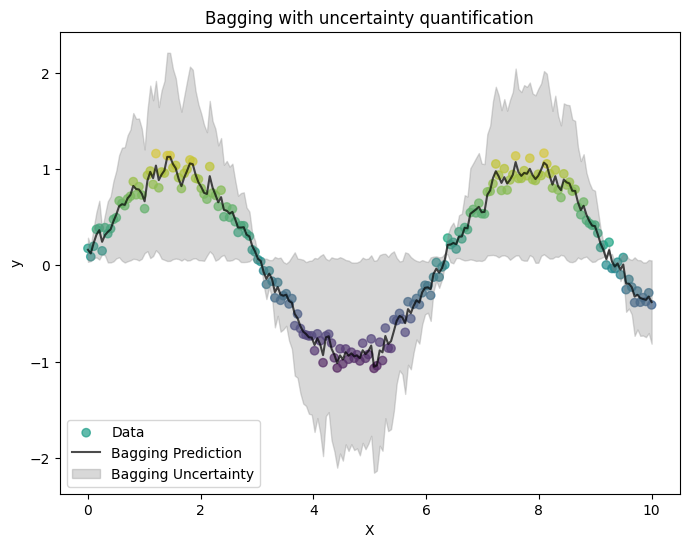

In [ ]:
np.random.seed(0)
X = np.linspace(0, 10, 200).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, X.shape[0])

bagging = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=0)
bagging.fit(X, y)
y_bagging_pred = bagging.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', label='Data Points', alpha=0.7) 

plt.plot(X, y_bagging_pred, color='black', label='Bagging Prediction', linewidth=1.5, alpha=0.7)
plt.fill_between(X.ravel(), 
                 y_bagging_pred - bagging.predict(X) + np.std([tree.predict(X) for tree in bagging.estimators_], axis=0),
                 y_bagging_pred + bagging.predict(X) - np.std([tree.predict(X) for tree in bagging.estimators_], axis=0),
                 color='grey', alpha=0.3, label='Bagging Uncertainty')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Bagging with uncertainty quantification')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 

In the context of uncertainty quantification, bagging can provide an estimate of prediction uncertainty by analyzing the variance among the predictions from different models. Higher variance indicates greater uncertainty. 
Bagging shows pretty high uncertainty with large grey shaded area in this case. 

</div>

### AdaBoost

<div align="justify"> 

Boosting can quantify uncertainty by examining the contribution of each model to the final prediction. If later models make significant corrections, it indicates higher uncertainty in the initial predictions.

</div>

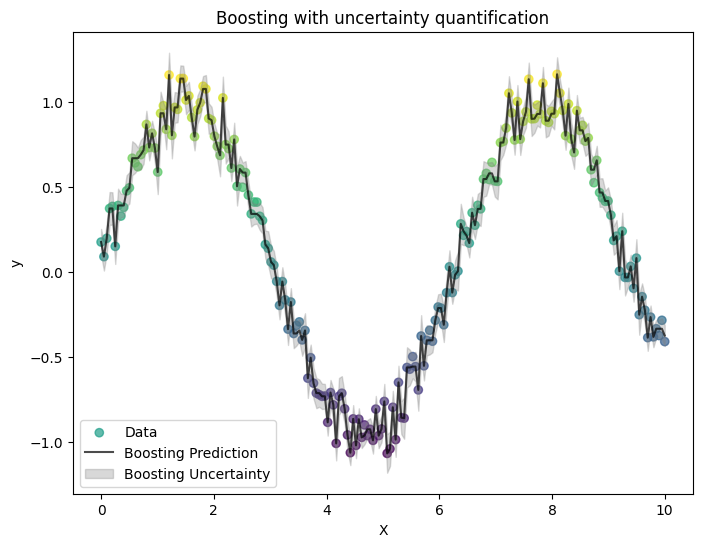

In [ ]:
boosting = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, random_state=0)
boosting.fit(X, y)
y_boosting_pred = boosting.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', label='Data Points', alpha=0.7) 

plt.plot(X, y_boosting_pred, color='black', label='Boosting Prediction', linewidth=1.5, alpha=0.7)
plt.fill_between(X.ravel(), 
                 y_boosting_pred - np.std([tree.predict(X) for tree in boosting.estimators_], axis=0),
                 y_boosting_pred + np.std([tree.predict(X) for tree in boosting.estimators_], axis=0),
                 color='grey', alpha=0.3, label='Boosting Uncertainty')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Boosting with uncertainty quantification')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 

Boosting can assess uncertainty based on the corrections made by subsequent models. 
This visualization helps in understanding the confidence levels of the predictions made by boosting. 
That is, boosting are very confident with very low uncertainty about the predictions. 

</div>

### Random Forest

<div align="justify"> 

Random forests create multiple decision trees during training by using different subsets of the data and a random subset of features for each tree. The final prediction is the average for regression like boosting methods. 

</div>

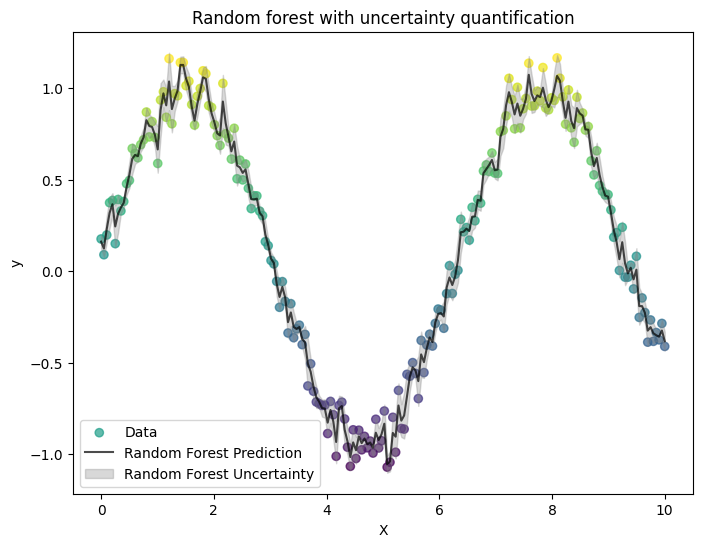

In [ ]:
random_forest = RandomForestRegressor(n_estimators=50, random_state=0)
random_forest.fit(X, y)
y_rf_pred = random_forest.predict(X)

plt.figure(figsize=(8, 6))
plt.scatter(X, y, c=y, cmap='viridis', marker='o', label='Data Points', alpha=0.7) 

plt.plot(X, y_rf_pred, color='black', label='Random Forest Prediction', linewidth=1.5, alpha=0.7)
plt.fill_between(X.ravel(), 
                 y_rf_pred - np.std([tree.predict(X) for tree in random_forest.estimators_], axis=0),
                 y_rf_pred + np.std([tree.predict(X) for tree in random_forest.estimators_], axis=0),
                 color='grey', alpha=0.3, label='Random Forest Uncertainty')

plt.xlabel('X')
plt.ylabel('y')
plt.title('Random forest with uncertainty quantification')
plt.legend(loc="lower left")
plt.show()

<div align="justify"> 


Random forests quantify uncertainty by analyzing the variance among the predictions from individual trees in the forest. 
Higher variance indicates greater uncertainty. 
Interestingly, the uncertainty measured by random forests and boosting is similar. 
One possible reason is that both boosting and random forests have mechanisms that inherently reduce uncertainty in predictions. 
Boosting algorithms, such as AdaBoost, sequentially train models where each model attempts to correct the errors of the previous one. 
This iterative correction process reduces the variance in predictions and leads to more confident predictions, hence narrower uncertainty regions. 
Random forests aggregate the predictions of many decision trees, each trained on a different random subset of the data. 
This averaging process reduces the overall variance and provides more stable and confident predictions, resulting in similar narrow uncertainty regions.

</div>